The model we are hoping to build looks like: 

V_ij = eps_ij $*$ (V_ii $*$ e^(-i $*$ pi $*$ tau_ci $*$ nu) + V_jj $*$ e^-i $*$ pi $*$  tau_cj $*$ nu)) 
        + P_ij * e^(-i * pi * tau_aij * nu) * (V_ii + V_jj)

The variables we are working with are: 

V_ij : the data averaged across time

eps_ij : the amplitude of the signal traveling through cables

        (getting the approx from: the amplitude array from outside baseline dependence; shape is Nbls by Nfreqs)

V_ii, V_jj : the autocorrelation for each of the two antennas

P_ij : the amplitude of the signal traveling through the air

        (getting the approx from: the amplitude array within baseline dependence; shape is Nbls by Nfreqs)

tau_ci, tau_cj : the "cable" delays 

        (getting the approx from: a row or column of amplitude array averaged across frequency)

tau_aij : the air delay 
        
        (getting the approx from: baseline length in ns)

nu : the frequency

        (getting the approx from: the frequency array)

In [2]:
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import cmath
#Import the functions I defined for this notebook
import amp_delay_plotting as adp

#Create uv elements
uvxy = UVData()
uvyx = UVData()
uvxx = UVData()
uvyy = UVData()

#Create constant variables
#Variable for the speed of light, with power adjusted for desired units
c = 0.299792
#Variable for speed of light in a cable correction factor, based on Google search
f = .83

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,98,136])

In [256]:
#Read each of the data files into the uv objects

# Read in the xy data file
uvxy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')

# Read in the yx data file
uvyx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/yx_time_split_data/combined_files/zen.grp1.of1.yx.LST.run_8.uvOCRSL.uvfits')

#Read in the xx data file
uvxx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xx_time_split_data/combined_files/zen.grp1.of1.xx.LST.run_2.uvOCRSL.uvfits')

#Read in the yy data file
uvyy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_yy_time_split_data/combined_files/zen.grp1.of1.yy.LST.run_2.uvOCRSL.uvfits')

In [257]:
print uvxy.freq_array.shape
print uvxy.data_array.shape
print uvxy.Nbls
print uvxy.Nfreqs

(1, 1024)
(1378, 1, 1024, 1)
1378
1024


Our arrays need to be Nbls by Nfreqs, or (1378,1024). 

We will need to create an array of zeros of the desired size and then extract the information from the file's original arrays. For instance, to create a data array of the correct size, we will need to create an array of zeros of size (1378,1024), and then equate the first dimension with the first dimension of the data array, and then the second dimenstion with the third dimension of the data array. 

In [258]:
#Read in the position and antenna numbers for all antennas
#These will be passed into functions to plot the antennas in the correct positions
antpos, ants = uvxy.get_ENU_antpos()

In [259]:
def find_bl_len(antnum1,antnum2):
    blin_length = 0
    #Step through each antenna pair with the entered antenna
    for aa,ant1 in enumerate(ants):
        for bb,ant2 in enumerate(ants):
            if (ant1 == antnum1 or ant1 == antnum2) and (ant2==antnum1 or ant2==antnum2):
                #Find the horizontal distance between the two antennas
                x = antpos[aa,0] - antpos[bb,0]
                #Find the vertical distance between the two antennas
                y = antpos[aa,1] - antpos[bb,1]
                #Find the hypotenus of the triangle, which is the total distance between
                #the two antennas
                diag = np.sqrt(x**2 + y**2)
                #Place this value into the array
                if diag != 0:
                    blin_length = diag
    return(blin_length)

In [260]:
xy_data_array = np.zeros([uvxy.Nbls,uvxy.Nfreqs])
print xy_data_array.shape
xy_freq_array = np.zeros([uvxy.Nbls,uvxy.Nfreqs])

print uvxy.data_array.shape
print uvxy.data_array[:,0,:,0,].shape
print uvxy.freq_array.shape

#test = np.array([[1,2,7],[3,4,8],[5,6,9]])
#print test[:,1] #this is the way to look at a specific column
#print test[2,:] #this is the way to look at a specific row

xy_freq_array[0:1] = uvxy.freq_array
print xy_freq_array.shape
print np.mean(xy_freq_array)
xy_data_array = uvxy.data_array[:,0,:,0,]
print np.mean(xy_data_array)

(1378, 1024)
(1378, 1, 1024, 1)
(1378, 1024)
(1, 1024)
(1378, 1024)
108817.97668722787
(0.0033089141+0.0070777163j)


In [261]:
#Create the arrays to be returned
blin_amp = np.zeros([uvxy.Nbls,uvxy.Nfreqs])
delays = np.zeros([uvxy.Nbls,uvxy.Nfreqs])

#Define constants for the beginning element that is within baseline 
#depenedence and the end element
blin_start = 471
blin_end = 554

for i,ant1 in enumerate(uvxy.ant_1_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_2_array[i]

    #Flag out dead antennas
    #If keep_flags is set to True, a zero entry will be added to the arrays
    #If keep_flags is set to False, the function continues
    if np.any(ant1==flagged_antennas):
        blin_amp[i] = 0
        delays[i] = 0
        continue

    if np.any(ant2==flagged_antennas):
        blin_amp[i] = 0
        delays[i] = 0
        continue

    # Check if the antenna numbers are equal
    #If they are, the function will continue
    #If keep_flags is set to True, a zero entry will be added to the arrays
    '''
    if ant1==ant2 and keep_flags:
        blin_amp.append([ant1,ant2,0])
        delays.append([ant1,ant2,0])
        continue
    elif ant1==ant2:
        continue
    '''
    if (ant1==11 and ant2==12) or (ant1==12 and ant2==11):
        # Create an array to hold the night's data
        spectrum = uvxy.data_array[i,0,:,0]
        print 'spectrum shape:',spectrum.shape
        # Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        print 'vis_avg_delay shape:',vis_avg_delay.shape
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uvxy.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs, freq_width))*1e9
        # Find the maximum amplitude and put into a variable
        blin_peak = np.max(np.abs(vis_avg_delay[blin_start:blin_end]))
        #If the peak is zero, meaning there is no peak, the delay is set to zero
        if blin_peak==0:
            blin_delay = 0
        else:
            #Find the corresponding delay
            blin_delay = con_delays[np.argwhere(np.abs(vis_avg_delay)==blin_peak)]
        # Append the maximum amplitude array with a list of the antenna pair and
        #the peak
        blin_amp[i] = blin_peak
        #Append the delay array with a list of the antenna pair and the delay
        delays[i] = blin_delay
    else: 
        blin_amp[i] = 0
        delays[i] = 0

#Convert to numpy arrays

print blin_amp.shape

print delays.shape

spectrum shape: (1024,)
vis_avg_delay shape: (1024,)
(1378, 1024)
(1378, 1024)


In [262]:
P_ij = blin_amp
nu = xy_freq_array

#Find the length of the baseline
tau_aij = find_bl_len(11,12)
print tau_aij

#Convert meters to ns
tau_aij = tau_aij / c
print tau_aij

#Get the autocorr data for the antennas
V_ii = uvxy.get_data(11,11)
print V_ii.shape
V_jj = uvxy.get_data(12,12)
print V_jj.shape

#Get the data
V_ij = uvxy.get_data(11,12)
print V_ij.shape

nu = uvxy.freq_array
print nu.shape

14.607949891367397
48.72695032344892
(1, 1024)
(1, 1024)
(1, 1024)
(1, 1024)


In [263]:
model1 = V_ij - (P_ij * np.e**(-1j * np.pi * tau_aij * nu) * (V_ii + V_jj))

print np.mean(model1)

(-0.002141728820990402-0.0004074153543027681j)


<IPython.core.display.Javascript object>


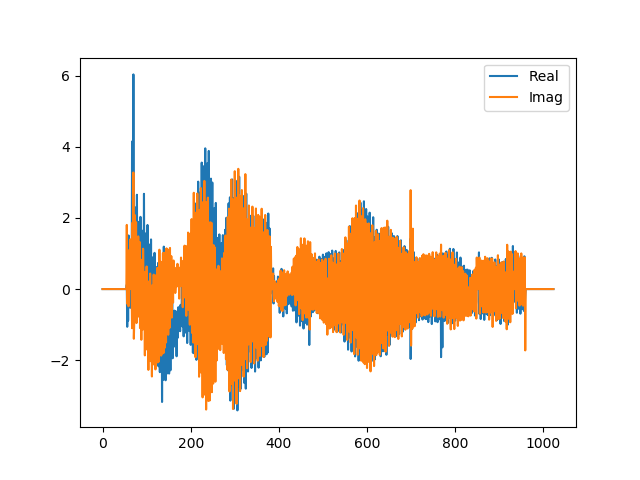

In [264]:
plt.figure()

plt.plot(np.mean(model1,axis=0).real,label='Real')
plt.plot(np.mean(model1,axis=0).imag, label='Imag')
plt.legend()

In [246]:
#Create the arrays to be returned
ind_amp = np.zeros([uvxy.Nbls,uvxy.Nfreqs])
ind_delays = np.zeros([uvxy.Nbls,uvxy.Nfreqs])

#Define constants for the beginning element that is within baseline 
#depenedence and the end element
blin_start = 471
blin_end = 554

for i,ant1 in enumerate(uvxy.ant_1_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_2_array[i]

    #Flag out dead antennas
    #If keep_flags is set to True, a zero entry will be added to the arrays
    #If keep_flags is set to False, the function continues
    if np.any(ant1==flagged_antennas):
        ind_amp[i] = 0
        ind_delays[i] = 0
        continue

    if np.any(ant2==flagged_antennas):
        ind_amp[i] = 0
        ind_delays[i] = 0
        continue

    # Check if the antenna numbers are equal
    #If they are, the function will continue
    #If keep_flags is set to True, a zero entry will be added to the arrays
    '''
    if ant1==ant2 and keep_flags:
        blin_amp.append([ant1,ant2,0])
        delays.append([ant1,ant2,0])
        continue
    elif ant1==ant2:
        continue
    '''
    if (ant1==11 and ant2==12) or (ant1==12 and ant2==11):
        # Create an array to hold the night's data
        spectrum = uvxy.data_array[i,0,:,0]
        print 'spectrum shape:',spectrum.shape
        # Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        print 'vis_avg_delay shape:',vis_avg_delay.shape
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uvxy.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs, freq_width))*1e9
        # Find the maximum amplitude and put into a variable
        peak_below_bl = np.max(np.abs(vis_avg_delay[:blin_start]))
        peak_above_bl = np.max(np.abs(vis_avg_delay[blin_end:]))
        #If the peak is zero, meaning there is no peak, the delay is set to zero
        if peak_below_bl >= peak_above_bl:
            peak_amp = peak_below_bl
        else: 
            peak_amp = peak_above_bl
        if peak_amp == 0: 
            delay = 0
        else:
            #Find the corresponding delay
            delay = con_delays[np.argwhere(np.abs(vis_avg_delay)==peak_amp)]
        # Append the maximum amplitude array with a list of the antenna pair and
        #the peak
        ind_amp[i] = peak_amp
        #Append the delay array with a list of the antenna pair and the delay
        ind_delays[i] = delay
    else: 
        ind_amp[i] = 0
        ind_delays[i] = 0

#Convert to numpy arrays

print ind_amp.shape

print ind_delays.shape

spectrum shape: (1024,)
vis_avg_delay shape: (1024,)
(1378, 1024)
(1378, 1024)


In [265]:
eps_ij = ind_amp
print eps_ij.shape

tau_ci = 1
tau_cj = 1

(1378, 1024)


In [266]:
model2 = V_ij - eps_ij*(V_ii * np.e**(-1j * np.pi * tau_ci * nu) + V_jj * np.e**(-1j * np.pi * tau_cj * nu)) + P_ij * np.e**(-1j * np.pi * tau_aij * nu) * (V_ii + V_jj)
print np.mean(model2)

(-0.013180844852829617-0.004340822278037905j)


<IPython.core.display.Javascript object>


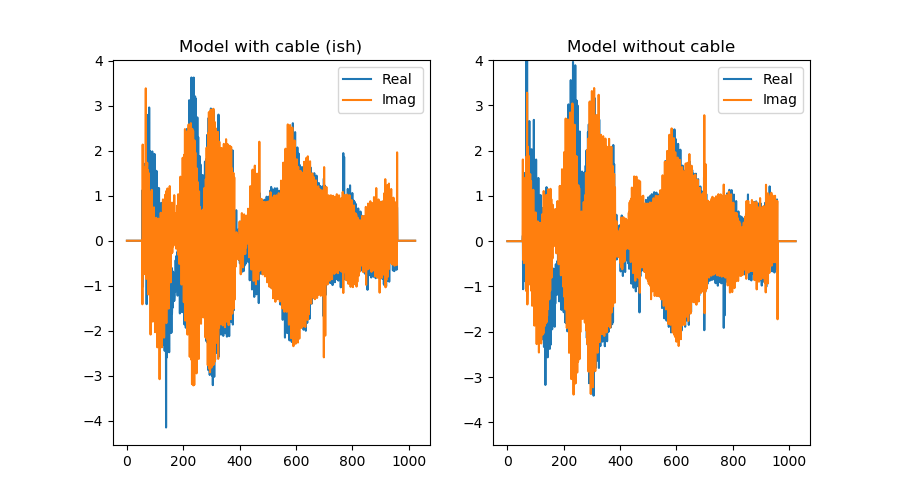

Text(0.5,1,'Model without cable')

In [273]:
plt.figure(figsize=(9,5))

plt.subplot(121)
plt.plot(np.mean(model2,axis=0).real,label='Real')
plt.plot(np.mean(model2,axis=0).imag, label='Imag')
plt.legend()
plt.title('Model with cable (ish)')

plt.subplot(122)
plt.plot(np.mean(model1,axis=0).real,label='Real')
plt.plot(np.mean(model1,axis=0).imag,label='Imag')
plt.legend()
plt.ylim(-4.5,4)
plt.title('Model without cable')

#plt.tight_layout()